In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
QiskitRuntimeService.save_account(
token="QSVF4eYHt90Tq-y2A46mzkXxJxVOOfGEOFQgZXu910UD", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
instance="crn:v1:bluemix:public:quantum-computing:us-east:a/4294337f3cef478f916e1cd2358d82b2:ccd2ed50-8403-4c53-b618-64eaec4b8220::", # Optional
overwrite=True
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit_aer import AerSimulator
from qiskit.circuit.library import n_local
from qiskit.primitives import BackendEstimatorV2
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime.options import EstimatorOptions

In [106]:
import numpy as np
from pyscf import ao2mo, gto, mcscf, scf

In [109]:
# Define molecule → geometry, charge, spin

distance = 0.735
a = distance / 2
mol = gto.Mole() # Creates a new molecule object
mol.build(
    verbose=4, #Suppresses output. PySCF often prints a lot of info about the molecule; 0 = quiet mode.
    atom=[
        ["H", (0, 0, -a)], # Defines atomic positions. Each entry: ["Element", (x, y, z)]
        ["H", (0, 0, a)],
    ],
    basis="sto-6g", # is a minimal basis set for electronic structure calculation: using 6 Gaussians to approximate 1 Slater orbital per atom.
    spin=0,
    charge=0,
    symmetry="Dooh", # Molecule symmetry group. “D₂h” is the full point group for a linear molecule.
)

mf = scf.RHF(mol) # Restricted Hartree-Fock calculation
mf.scf()
 
print(
    mf.energy_nuc(), # The Coulomb energy between the nuclei
    mf.energy_elec()[0], # Energy of electrons moving in the field of the nuclei, computed by Hartree-Fock. [0] is the ground-state energy.
    mf.energy_tot(),
    mf.energy_tot() - mol.energy_nuc(),
)

active_space = range(mol.nelectron // 2 - 1, mol.nelectron // 2 + 1)


# This is the energy that VQE will try to approximate using qubits and ansatz.

# mf contains all the molecular orbitals, which you can feed into Qiskit’s Hartree-Fock initial state or UCCSD ansatz.

System: uname_result(system='Linux', node='lgpm', release='6.8.0-90-generic', version='#91~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Thu Nov 20 15:20:45 UTC 2', machine='x86_64')  Threads 8
Python 3.10.12 (main, Jan  8 2026, 06:52:19) [GCC 11.4.0]
numpy 2.2.6  scipy 1.15.3  h5py 3.15.1
Date: Tue Jan 27 14:08:48 2026
PySCF version 2.12.0
PySCF path  /home/msosnova/msosnova/Supelec_2023/Notebooks/notebook_Quantum-computing/Quantum_Computing_venv/lib/python3.10/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry Dooh subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000  -0.367500000000 AA    0.000000000000   0.000000000000  -0.694474350778 Bohr   0.0
[INPUT]  2 H      0.000000000000  

In [108]:
# Generate fermionic Hamiltonian

E1 = mf.kernel() # converged RHF energy for H₂ (in Hartree).
mx = mcscf.CASCI(mf, ncas=2, nelecas=(1, 1)) # Complete Active Space Configuration Interaction. Used to treat strong electron correlation beyond Hartree-Fock.
#ncas=2 → number of active orbitals (here, 2 orbitals for H₂ bonding/antibonding).
#nelecas=(1,1) → number of electrons in active space: 1 alpha, 1 beta electron (H₂ has 2 electrons total, active in bonding/antibonding orbitals).
mo = mx.sort_mo(active_space, base=0)
E2 = mx.kernel(mo)[:2] # energies of the electronic states (ground + excited).

h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)



******** <class 'pyscf.scf.hf_symm.SymAdaptedRHF'> ********
method = SymAdaptedRHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
diis_damp = 0
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /tmp/tmpexzwr95u
max_memory 4000 MB (current use 1410 MB)
Freeze 0 electrons in irreps []
    2 free electrons in irreps A1g A1u
Set gradient conv threshold to 3.16228e-05
init E= -1.12562866842744
HOMO (A1g) = -0.584970785205619  LUMO (A1u) = 0.673146116787527
cycle= 1 E= -1.12562866842744  delta_E=    0  |g|=    0  |ddm|=    0
HOMO (A1g) = -0.584970785205619  LUMO (A1u) = 0.673146116787527
Extra cycle  E= -1.12562866842744  delta_E=    0  |g|=    0  |ddm|=    0
converged SCF energy = -1.12562866842744
Symmetries of active orbitals: A1g A1u
Active space CI wfn symmetry = A1g

******** <class 'pyscf.mcscf.casci_symm.Sym

In [110]:
def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng

In [111]:
def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])
 
 
def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                ell, r = "I" * (n - 1), ""
            elif p == n - 1:
                ell, r = "", "Z" * (n - 1)
            else:
                ell, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(ell + "X" + r, 0.5), (ell + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list

In [112]:
def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape
 
    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)
 
    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)
 
    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg
 
    return H.chop().simplify()

In [113]:
H = build_hamiltonian(ecore, h1e, h2e)
print(H)

accuracy of Cholesky decomposition  1.8768594323382656e-16
SparsePauliOp(['IIII', 'IIIZ', 'IZII', 'IIZI', 'ZIII', 'IZIZ', 'IIZZ', 'ZIIZ', 'IZZI', 'ZZII', 'ZIZI', 'YYYY', 'XXYY', 'YYXX', 'XXXX'],
              coeffs=[-0.09820182+0.j,  0.1740751 +0.j,  0.1740751 +0.j, -0.2242933 +0.j,
 -0.2242933 +0.j,  0.16891402+0.j,  0.1210099 +0.j,  0.16631441+0.j,
  0.16631441+0.j,  0.1210099 +0.j,  0.17504456+0.j,  0.04530451+0.j,
  0.04530451+0.j,  0.04530451+0.j,  0.04530451+0.j])


     ┌──────────┐┌───┐     ┌──────────┐   ┌───┐                     
q_0: ┤ Rx(θ[0]) ├┤ Y ├──■──┤ Rx(θ[4]) ├───┤ Y ├─────────────────────
     ├──────────┤├───┤┌─┴─┐└──────────┘┌──┴───┴───┐   ┌───┐         
q_1: ┤ Rx(θ[1]) ├┤ Y ├┤ X ├─────■──────┤ Rx(θ[5]) ├───┤ Y ├─────────
     ├──────────┤├───┤└───┘   ┌─┴─┐    └──────────┘┌──┴───┴───┐┌───┐
q_2: ┤ Rx(θ[2]) ├┤ Y ├────────┤ X ├─────────■──────┤ Rx(θ[6]) ├┤ Y ├
     ├──────────┤├───┤        └───┘       ┌─┴─┐    ├──────────┤├───┤
q_3: ┤ Rx(θ[3]) ├┤ Y ├────────────────────┤ X ├────┤ Rx(θ[7]) ├┤ Y ├
     └──────────┘└───┘                    └───┘    └──────────┘└───┘
7


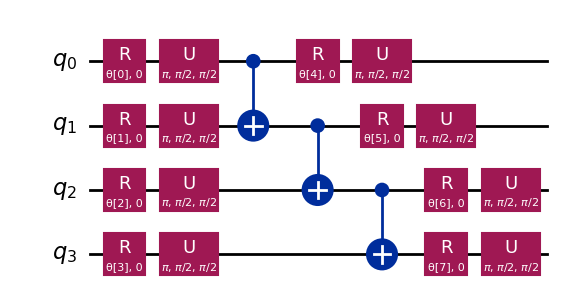

In [129]:
from qiskit.circuit.library import efficient_su2
 
SU2_ansatz = efficient_su2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
print(SU2_ansatz.draw())
print(SU2_ansatz.decompose().depth())
SU2_ansatz.decompose().draw(output="mpl")


In [118]:
cost_func,
x0,
args=(ansatz, H, estimator),
method="cobyla",
options={"maxiter": 200}

In [123]:
# General imports
import numpy as np
from qiskit.quantum_info import SparsePauliOp
 
# Hamiltonian obtained from a previous lesson
 
H = SparsePauliOp(
    [
        "IIII",
        "IIIZ",
        "IZII",
        "IIZI",
        "ZIII",
        "IZIZ",
        "IIZZ",
        "ZIIZ",
        "IZZI",
        "ZZII",
        "ZIZI",
        "YYYY",
        "XXYY",
        "YYXX",
        "XXXX",
    ],
    coeffs=[
        -0.09820182 + 0.0j,
        -0.1740751 + 0.0j,
        -0.1740751 + 0.0j,
        0.2242933 + 0.0j,
        0.2242933 + 0.0j,
        0.16891402 + 0.0j,
        0.1210099 + 0.0j,
        0.16631441 + 0.0j,
        0.16631441 + 0.0j,
        0.1210099 + 0.0j,
        0.17504456 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
        0.04530451 + 0.0j,
    ],
)
 
nuclear_repulsion = 0.7199689944489797

5


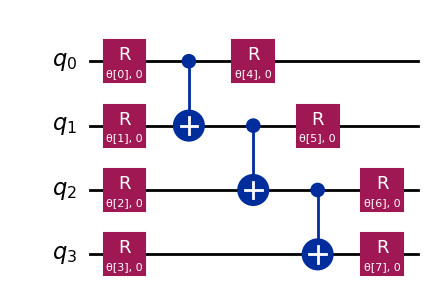

In [126]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2
 
# SciPy minimizer routine
from scipy.optimize import minimize
 
# Plotting functions
 
# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
# SU2_ansatz = efficient_su2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)

x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")

In [95]:
def cost_func(params, ansatz, H, estimator):
    pub = (ansatz, [H], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    return energy
 
# def cost_func_sim(params, ansatz, H, estimator):
#    energy = estimator.run(ansatz, H, parameter_values=params).result().values[0]
#    return energy

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(channel="ibm_quantum_platform")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_marrakesh'

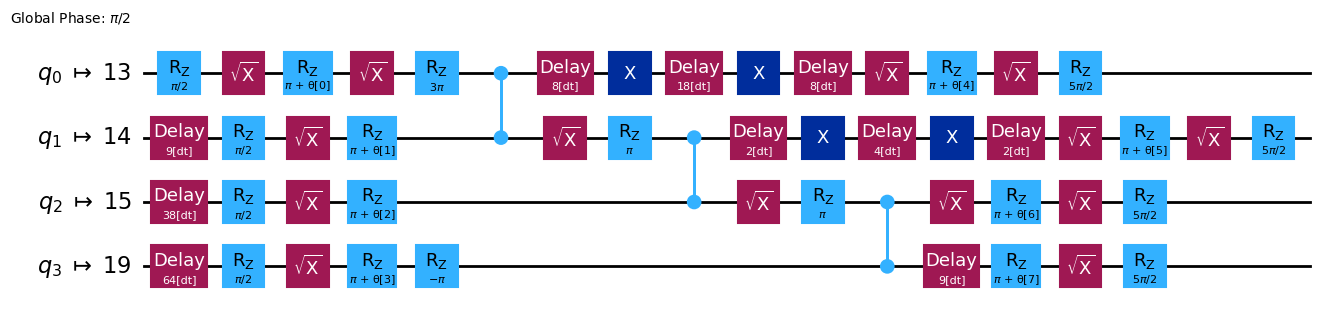

In [130]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
    ConstrainedReschedule,
)
from qiskit.circuit.library import XGate
 
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)
 
 
# Use the pass manager and draw the resulting circuit
ansatz_isa = pm.run(ansatz)
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [131]:
hamiltonian_isa = H.apply_layout(ansatz_isa.layout)
hamiltonian_isa

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIII

In [132]:
# We will start by using a local simulator
from qiskit_aer import AerSimulator
 
# Import an estimator, this time from qiskit (we will import from Runtime for real hardware)
from qiskit.primitives import BackendEstimatorV2
 
# generate a simulator that mimics the real quantum system
backend_sim = AerSimulator.from_backend(backend)
estimator = BackendEstimatorV2(backend=backend_sim)

In [133]:
res = minimize(
    cost_func,
    x0,
    args=(ansatz_isa, hamiltonian_isa, estimator),
    method="cobyla",
    options={"maxiter": 10, "disp": True},
)
 
print(getattr(res, "fun") - nuclear_repulsion)
print(res)

-0.9144132157380421
   Return from subroutine COBYLA because the MAXFUN limit has been reached.


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.1944442212890625
       x: [ 5.680e+00  2.214e+00  4.562e+00  3.610e+00  4.241e+00
            1.692e-01  3.246e+00  3.582e+00]
    nfev: 10
   maxcv: 0.0
   NFVALS =   10   F =-1.944442E-01    MAXCV = 0.000000E+00
   X = 5.679669E+00   2.214006E+00   4.562207E+00   3.610046E+00   4.240881E+00
       1.691931E-01   3.245903E+00   3.582273E+00


In [103]:
print(getattr(res, "fun") - nuclear_repulsion)
print(res)

-1.0839960057624562
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.36402701131347653
       x: [ 1.924e+00  7.080e+00  6.055e+00  5.650e-01  2.280e+00
            3.143e+00  7.083e-01  6.045e+00]
    nfev: 10
   maxcv: 0.0


In [104]:
import qiskit
import qiskit_ibm_runtime
 
print(qiskit.version.get_version_info())
print(qiskit_ibm_runtime.version.get_version_info())

2.3.0
0.43.1
